In [41]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import utils
from torchsummary import summary
from PIL import Image
from PIL import Image, ImageDraw

from logger import logger
import utils as utils

pd.set_option('display.max_columns', 500)
%matplotlib inline
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Device Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Device type: {device}")

2022-02-07 17:46:09,960 INFO Device type: cpu


In [19]:
os.listdir('./histopathologic-cancer-detection/')

['sample_submission.csv', 'test', 'train', 'train_labels.csv']

In [27]:
train_labels = os.path.join(os.path.abspath(
    os.getcwd()), 'histopathologic-cancer-detection', 'train_labels.csv')
train_dir = os.path.join(os.path.abspath(
    os.getcwd()), 'histopathologic-cancer-detection', 'train')
test_dir = os.path.join(os.path.abspath(
    os.getcwd()), 'histopathologic-cancer-detection', 'test')

In [28]:
train_labels_df = pd.read_csv(train_labels)
train_labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [34]:
null_df = utils.check_null_values(train_labels_df)
null_df

,columns,percent_null,percent_zero,percent_one
id,id,0.0,0.000000,0.000000
label,label,0.0,59.496875,40.503125


In [37]:
count_values = utils.count_values(train_labels_df, 'label')
count_values

0    130908
1     89117
Name: label, dtype: int64

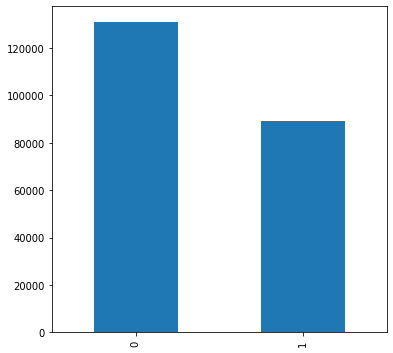

In [40]:
utils.GeneratePlot((6, 6), train_labels_df['label'], 'bar')

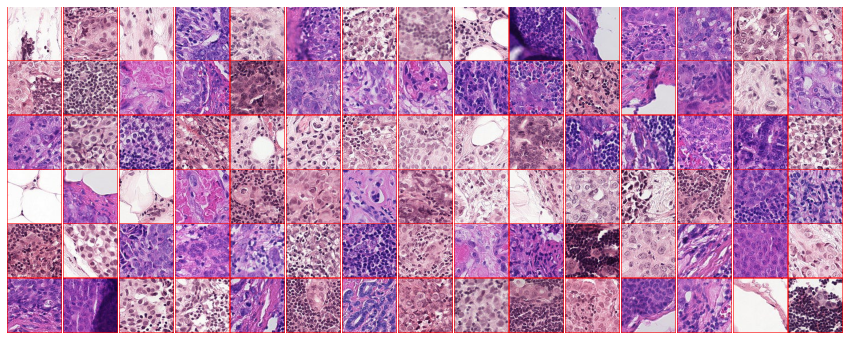

In [42]:
# get the ids of malignant cases
malignant = train_labels_df.loc[train_labels_df['label'] ==1]['id'].values  
# get the ids of the normal cases
normal = train_labels_df.loc[train_labels_df['label'] == 0]['id'].values

nrows, ncols = 6, 15
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 6))
plt.subplots_adjust(wspace=0, hspace=0)
for i, j in enumerate(malignant[:nrows*ncols]):
    fname = os.path.join(train_dir, j + '.tif')
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0, 0), (95, 95)), outline='red')
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(np.array(img))
    plt.axis('off')


In [13]:
# Neural Networ Predefined Parameters
params_model={
    "shape_in": (3,96,96), 
    "initial_filters": 8,    
    "num_fc1": 100,
    "dropout_rate": 0.25,
    "num_classes": 2}


In [14]:
class Network(nn.Module):

    # Network Initialisation
    def __init__(self, params):

        super(Network, self).__init__()

        Cin, Hin, Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h, w = findConv2dOutShape(Hin, Win, self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv4)

        # compute the flatten size
        self.num_flatten = h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, X):

        # Convolution & Pool Layers
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten)

        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)
